## Packages

In [17]:
import os.path as osp
from pathlib import Path
from time import time
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import librosa

from IPython.display import Audio, clear_output, display

In [18]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

## Arguments

In [19]:
bert_model = "bert-base-uncased"
pretrained_model = (
    "../models/bert_pretrained/"  # Expects the pre-trained weights to exist
)
transcripts_path = "../outputs/all_transcripts_v2.csv"
device = "cpu"

## User-Defined Functions

In [20]:
class GrandStand_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, info):
        self.encodings = encodings
        self.labels = labels
        self.info = info

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["info"] = self.info[idx]
        return item

    def __len__(self):
        return len(self.labels)

## Load Transcript

In [21]:
transcripts = pd.read_csv(transcripts_path)
transcripts.sample(n=5)

,file,line,start,end,speaker,speaker_role,word_count,duration,text
96,12-1036,191,3448.946,3453.195,Antonin_Scalia,scotus_justice,10,4.249,Did not the Fifth Circuit decide that State la...
43,12-1036,86,1683.706,1710.290,Sonia_Sotomayor,scotus_justice,59,26.584,So how do you remand a case when it involves u...
257,12-138,73,2003.816,2029.166,Elena_Kagan,scotus_justice,64,25.350,"Because you read this through your brief, and ..."
458,12-515,296,3621.849,3646.082,Stephen_G_Breyer,scotus_justice,75,24.233,They didn't participate in the convention and ...
222,12-138,4,72.212,126.164,Sonia_Sotomayor,scotus_justice,128,53.952,All right. So if the issue is what did the par...


In [22]:
print("# Cases:", transcripts["file"].nunique())
print("# Speech Segments:", transcripts.shape[0])

# Cases: 5
# Speech Segments: 565


In [23]:
text = transcripts["text"].tolist()
metadata = transcripts.apply(lambda x: (x["file"], x["line"]), axis=1).tolist()
fake_labels = [0 for i in range(transcripts.shape[0])]

## Load BERT Pre-Trained Weights

In [24]:
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [25]:
st = time()

scotus_encoder = tokenizer(text, truncation=True, padding=True)
scotus_dataset = GrandStand_Dataset(scotus_encoder, fake_labels, metadata)

print(f"{round(time() - st, 2)}s")

0.41s


In [26]:
st = time()
model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=1)

model.load_state_dict(torch.load("../models/bert_pretrained/BERTforGS"))
model.eval()
model.to(device)

print(f"{round(time() - st, 2)}s")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

1.86s


## Generate Scores

In [27]:
st = time()

inputs = []
grandstanding_scores = []
for i, batch in enumerate(scotus_dataset):
    clear_output(wait=True)
    print("Item", i)
    print(f"Elapsed Time: {round(time() - st, 2)}s")
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        file_info = batch["info"]
        outputs = model(
            input_ids.reshape(1, -1), attention_mask=attention_mask.reshape(1, -1)
        )
        score = outputs.logits[0].item()
        grandstanding_scores.append((file_info, score))

print(f"Total Time: {round(time() - st, 2)}s")

Item 564
Elapsed Time: 438.54s
Total Time: 439.34s


In [28]:
gs_df = pd.DataFrame(
    data=[(i[0], i[1], s) for (i, s) in grandstanding_scores],
    columns=["file", "line", "gs_score"],
)
gs_df.sample(n=5)

,file,line,gs_score
425,12-515,233,-1.352348
318,12-515,25,0.152592
141,12-1038,70,-0.233303
282,12-138,121,-0.111669
357,12-515,101,-0.778577


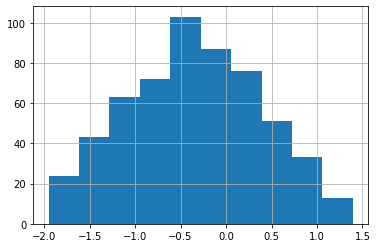

In [29]:
_ = gs_df["gs_score"].hist()

In [30]:
gs_df.to_csv("../outputs/bert_scores.csv")